In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras import optimizers
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import os

# UNETs
from keras_unet.models import satellite_unet
from keras_unet.models import custom_unet

C:\Users\Aiman\Anaconda3\envs\sticker\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


In [2]:
def batch_ssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


def batch_msssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0))


def batch_psnr(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))


def batch_nmse(y_true, y_pred):
    return tf.divide(tf.reduce_sum(tf.squared_difference(y_true, y_pred)), tf.reduce_sum(y_true ** 2))


def loss_func(labels, predictions):
        return 1 - tf.image.ssim(labels, predictions, max_val=15.0)

In [3]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")

In [4]:
SAVE_DATA_PATH = os.path.join(TRAIN_DATASET_PATH, "singlecoil_train_2D_images/")
SAVE_DATA_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset\\singlecoil_train_2D_images/'

In [5]:
x_train = np.load("{}/x_train_sub.npy".format(SAVE_DATA_PATH))
y_train = np.load("{}/y_train_sub.npy".format(SAVE_DATA_PATH))

x_train.shape, y_train.shape

((15000, 320, 320, 1), (15000, 320, 320, 1))

In [6]:
def show_slices(data, slice_nums, cmap=None):
    data = data.reshape((data.shape[0], 320,320))
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)        

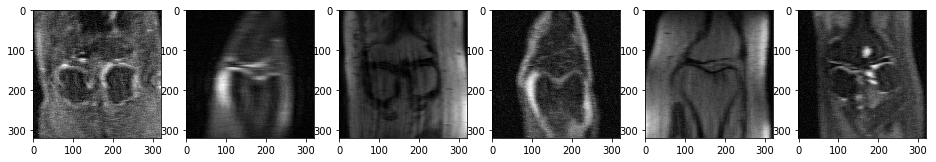

In [7]:
slice_nums = [27, 50, 100, 2000, 5510, 6515]
show_slices(x_train, slice_nums, cmap='gray')

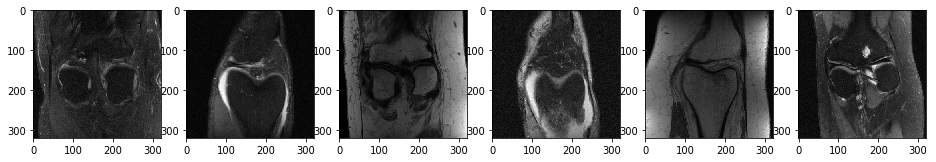

In [8]:
show_slices(y_train, slice_nums, cmap='gray')

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

np.save("{}/x_train_sub.npy".format(SAVE_DATA_PATH), x_train_sub)
np.save("{}/y_train_sub.npy".format(SAVE_DATA_PATH), y_train_sub)

In [9]:
model=None

In [10]:
def u1():
    inputs = Input((320, 320, 1))
    #s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae', metrics=[batch_ssim, batch_psnr, batch_msssim, batch_nmse])
    return model


In [11]:
model = None

def u2():
    model = satellite_unet(input_shape=(320, 320, 1))
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae', metrics=[batch_ssim, batch_psnr, batch_msssim, batch_nmse])
    return model

def u3():
    model = model = custom_unet(
    (320, 320, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae', metrics=[batch_ssim, batch_psnr, batch_msssim, batch_nmse])
    return model

model = u2()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 320, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 64) 36928       batch_normalization_1[0][0]      
_____________________________________

In [12]:
x_train.shape, y_train.shape

((15000, 320, 320, 1), (15000, 320, 320, 1))

In [ ]:
checkpointer = ModelCheckpoint(filepath='unet_v2.h5', verbose=1, monitor='val_loss', save_best_only=True)
#callbacks=[checkpointer]

h = model.fit(x_train, y_train, validation_split=0.1, batch_size=2, epochs=300)

Train on 13500 samples, validate on 1500 samples
Epoch 1/300
13500/13500 [==============================] - 2292s 170ms/step - loss: 1.8308e-04 - batch_ssim: 0.9990 - batch_psnr: 94.7028 - batch_msssim: 0.9993 - batch_nmse: 38965.0114 - val_loss: 1.2396e-05 - val_batch_ssim: 1.0000 - val_batch_psnr: 96.9688 - val_batch_msssim: 1.0000 - val_batch_nmse: 0.0718
Epoch 2/300
13500/13500 [==============================] - 2286s 169ms/step - loss: 1.3725e-05 - batch_ssim: 1.0000 - batch_psnr: 96.5803 - batch_msssim: 1.0000 - batch_nmse: 0.0981 - val_loss: 1.1147e-05 - val_batch_ssim: 1.0000 - val_batch_psnr: 97.5419 - val_batch_msssim: 1.0000 - val_batch_nmse: 0.0612
Epoch 3/300
13500/13500 [==============================] - 2282s 169ms/step - loss: 1.1037e-05 - batch_ssim: 1.0000 - batch_psnr: 98.3479 - batch_msssim: 1.0000 - batch_nmse: 0.0630 - val_loss: 1.4901e-05 - val_batch_ssim: 1.0000 - val_batch_psnr: 96.0309 - val_batch_msssim: 1.0000 - val_batch_nmse: 0.0926
Epoch 4/300
13500/13500

In [24]:
h = model.history

In [15]:
model.save("unet_v2.h5")

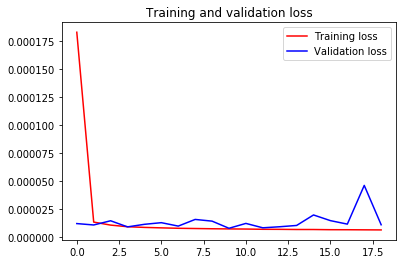

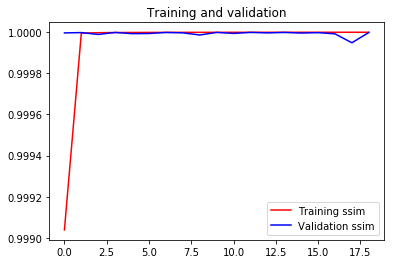

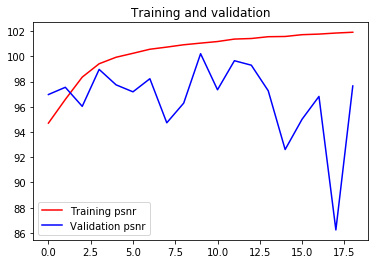

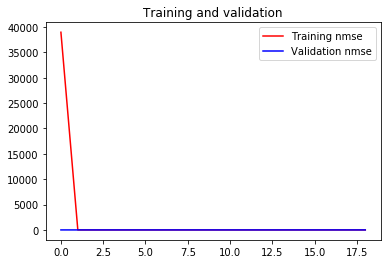

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt

loss = h.history['loss']
val_loss = h.history['val_loss']

ssim = h.history['batch_ssim']
val_ssim = h.history['val_batch_ssim']

psnr = h.history['batch_psnr']
val_psnr = h.history['val_batch_psnr']

nmse = h.history['batch_nmse']
val_nmse = h.history['val_batch_nmse']

epochs = range(len(loss))


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, ssim, 'r', label='Training ssim')
plt.plot(epochs, val_ssim, 'b', label='Validation ssim')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, psnr, 'r', label='Training psnr')
plt.plot(epochs, val_psnr, 'b', label='Validation psnr')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, nmse, 'r', label='Training nmse')
plt.plot(epochs, val_nmse, 'b', label='Validation nmse')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.show()
